# **Tools Recognition**

In [1]:
import os
import cv2
import json
import glob
import numpy as np
import seaborn as sns
from tqdm import tqdm
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from skimage.measure import euler_number
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

---
### 1) Raccolta e etichettatura delle immagini

Creiamo il nostro dataset di train e test etichettando le varie immagini e considerando varie situazioni: diverse posizioni degli oggetti, cambi di luminosità, presenza di ombre e diversi sfondi, alcuni dei quali presentano delle irregolarità.

- 10 diverse categorie:
    - accendino
    - cacciavite
    - chiave
    - forbici
    - martello
    - metro
    - nastro
    - pappagallo
    - penna
    - spillatrice 

- 4 diverse superfici:
    - tavolo bianco
    - banco da lavoro
    - pavimento di cemento
    - coperta a righe
- 20 immagini per allenare il modello di classificazione per ogni categoria
- 12 immagini per il test contenenti oggetti multipli

Le gli oggetti non toccano i bordi e non si toccano fra di loro.


In [2]:
# Oggetti utilizzati.
tool_names = ['accendino', 'cacciavite', 'chiave', 'forbici', 'martello', 'metro', 'nastro', 'pappagallo', 'penna', 'spillatrice']

In [4]:
# Rinomiamo le immagini nelle cartelle.
cwd = os.getcwd()
for tool in tool_names:
    path = os.path.join(cwd, f"images/{tool}/")
    image_files = glob.glob(path + '*.png')

    for i, file in enumerate(image_files):
        new_name = tool+ '_' + str(i+1) + '.png'
        os.rename(file, os.path.join(path, new_name))


# Rinominiamo le immagini del test.
path = os.path.join(cwd, f"images/Test_set/")
image_files = glob.glob(path + '*.png')

for i, file in enumerate(image_files):
    new_name = 'test_' + str(i+1) + '.png'
    os.rename(file, os.path.join(path, new_name))

---
### 2) Pre-elaborazione delle immagini

Prima della segmentazione creiamo un *ground truth* per ogni immagine in modo tale da poter valutare lo step successivo in temini di accuratezza e modifichiamo le immagini per preparale per i prossimi step: ridimensioniamo le immagini riducendole tutte alla stessa dimensione (520 x 520 pixel) e le ricoloriamo in scala di grigi per ridurle ad un singolo canale e renderle più pratiche e semplici da elaborare.

- Ridimensionamento : portartiamo nello stesso formato tutte le immagini (520 x 520). Alcune delle utilità di questo passaggio possono essere una maggiore uniformità una volta che si va ad allenare l'algoritmo di calssificazione e l'aumento della diversità dei dati di training che possono portare il modello ad avere una maggiore robustezza;

In [ ]:
# Portiamo tutte le immagini nella stessa dimensione (520 x 520).
cwd = os.getcwd()

for tool in tool_names:
    path = os.path.join(cwd, f"images/{tool}/")
    image_files = glob.glob(path + '*.png')

    for i, file in enumerate(image_files):
        image = Image.open(file)

        # Ridimensionamento dell'immagine.
        resized_image = image.resize((520, 520))
        resized_image.save(file)

# test-set
path = os.path.join(cwd, f"images/Test_set/")
image_files = glob.glob(path + '*.png')

for i, file in enumerate(image_files):
    image = Image.open(file)

    # Ridimensionamento dell'immagine.
    resized_image = image.resize((520, 520))
    resized_image.save(file)

- Ricolorazione: applichiamo la scalda di grigi riducendo le immagini ad un unico canale rendendole più semplici da analizzare;
- Gaussian Filter: applichiamo un `Gaussian filter` con dimensione 5x5 per sfocare l'immagine e rendere lo sfondo piu semplice da distinguere rispetto agli oggetti.

Queste due tecninche le applichiamo direttamente prima della segmentazione nello ste successivo.

---
### 3) Segmentazione delle immagini 

Una volta ottenuto l'immagine preparata, si applica un metodo di segmentazione per dividere l'immagine in regioni omogenee. Abbiamo provato ad utilizzare tecniche di segmentazione come la segmentazione basata sulla soglia, la segmentazione basata sulla regione o la segmentazione basata sui cluster: queste tecniche non hanno portato buoni risultati perchè, anche se identificano molto bene gli oggetti con una precisione quasi sempre superiore al 90%, con altrettanta precisione sbagliano ad identificare lo sfondo a causa della presenza di ombre e di sfondi che non permetono una chiara distinzione con l'oggetto considerato e presentano delle imperfezioni. Confrontiamo perciò alcune tecniche di segmentazione sulle immagini a sfondo bianco.

Tecniche di segmentazione:
- per contorni: Canny edge detector

- per regioni: sogliatura automatica OTSU

- mediante clustering: k-mean


In [30]:
tools = ['accendino', 'cacciavite', 'chiave', 'forbici', 'martello', 'metro', 'nastro', 'pappagallo', 'penna', 'spillatrice']
tp_tot, tn_tot, fp_tot, fn_tot = [], [], [], []

cwd = os.getcwd()
folder_path = os.path.join(cwd, f"new_images")


for tool in tqdm(tools):

    with open(f"{folder_path}\{tool}\{tool}_gt.json", 'r') as f:
        ground_truth_file = json.load(f)

    for pos, el in enumerate(ground_truth_file):

        truth_mask = np.zeros((520, 520))
        image = cv2.imread(f"{folder_path}\{tool}\{tool}_{pos+1}.png")

        for i in range(len(ground_truth_file[el]['regions'])):

            x_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_x']
            y_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_y']
            vertices = np.array([[x_pos[u], y_pos[u]] for u in range(len(x_pos))])
            if i == 0:
                    cv2.fillPoly(truth_mask, [vertices], 255)
            else:
                    cv2.fillPoly(truth_mask, [vertices], 0)

        # Ground truth.
        x_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_x']
        y_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_y']
        vertices = np.array([[x_pos[i], y_pos[i]] for i in range(len(x_pos))])

        # Preprocessing.
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), cv2.BORDER_DEFAULT)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        gray = cv2.erode(gray, kernel, iterations=3)


        ## Tecniche di segmentazione.

        # # 1) Sogliaura di OTSU
        # _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        # # 2) K-means
        # small = cv2.pyrDown(gray)
        # Z = small.reshape((-1, 1))
        # Z = np.float32(Z)
        # criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        # K = 2
        # ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        # center = np.uint8(center)
        # res = center[label.flatten()]
        # res2 = res.reshape((small.shape))
        # res2 = cv2.pyrUp(res2)
        # _, mask = cv2.threshold(res2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # 3) CANNY Edge Detection
        edges = cv2.Canny(gray, threshold1=100, threshold2=200)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        mask = nd.binary_fill_holes(closed_edges)
        mask = mask.astype(np.uint8) * 255


        # cv2.imshow("Masked Image", mask)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()


        # Ground truth mask.
        truth_mask = truth_mask.astype(bool).flatten()
        opening = mask.astype(bool)

        # Confronto tra segmentazione e ground truth.
        ground_truth = truth_mask.flatten()
        predictions = [elem for elem in opening.flatten()]

        tn, fp, fn, tp = confusion_matrix(ground_truth, predictions, labels=[True, False]).ravel()
        tp_tot.append(tp)
        tn_tot.append(tn)
        fp_tot.append(fp)
        fn_tot.append(fn)


# Matrice di Confusione.
sum_tp, sum_tn, sum_fp, sum_fn = sum(tp_tot), sum(tn_tot), sum(fp_tot), sum(fn_tot) 

cf_matrix = np.array([[sum_tp/(sum_tp+sum_fp), sum_fp/(sum_tp+sum_fp)],
                       [sum_fn/(sum_tn+sum_fn), sum_tn/(sum_tn+sum_fn)]])

100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


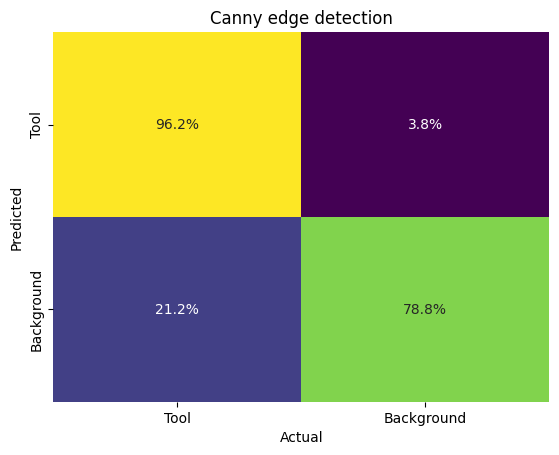

In [31]:
labels = ['Tool', 'Background']
sns.heatmap(cf_matrix, annot=True, cmap='viridis',  xticklabels=labels, yticklabels=labels, cbar=False, fmt=".1%")
plt.title("Canny edge detection")
plt.xlabel('Actual')
plt.ylabel('Predicted');

<img src="Prove_segmentazione\Canny_edge_detection.png"  width="30%" height="30%">
<img src="Prove_segmentazione\k_means.png"  width="30%" height="30%">
<img src="Prove_segmentazione\Sogliatura_Otsu.png"  width="30%" height="30%">


Problemi:
- **Ombre**, andando a segmentare l'immagine le ombre tendono ad essere classificate come l'oggetto e infatti notiamo come per tutti i metodi ci sia una buona percentuale di falsi positivi, ovvero lo sfondo viene riconosciuto erroneamente come oggetto;
- **Sfondo**, gli sfondi utilizzati creano diversi problemi alle tecinche di segmentazione che non riescono adeliminare i pattern presenti, es. i pallini del tavolo da lavoro o le strisce della coperta, e portano perciò ad una segmentazione degli oggetti erronea, aumetanto notevolmente la percentuale di pixel classificati come oggetti quando questi appartengono allo sfondo.


''' Confrontiamo alcune tecninche di segmentazione sulle immagini a sfondo bianco (vedi Prove Tecninche di Segmentazione) e notiamo come la sogliatura per contorni risulti la migliore perchè riesce ad andare ad identificare in aniera abbastanza corretta i bordi delle immagini non classificando lo sfondo come oggetto. Continuiamo la nostra analisi utilizzando il ground truth per l'estazione delle features e la classificazinoe degli oggetti.'''

---
### 4) Estrazione delle features

Le features che andiamo ad estrarre da ogni immagine per allenare in nostro modello sono:

- `Numero di Eulero`: verifica la presenza di buchi all'interno dell'immagine segmentata;
- `Momenti di Hu`: set di sette momenti invarianti alle trasformazioni di scala, rotazione e traslazione;
- `Rapporto degli assi dell'ellisse`: rapporto degli assi dell'ellisse all'interno del quale è contenuta l'immagine segmentata.

In [18]:
tools = ['accendino', 'cacciavite', 'chiave', 'forbici', 'martello', 'metro','nastro', 'pappagallo', 'penna', 'spillatrice']
feat_euler, feat_hu, feat_axis = [], [], []
y_labels = []

# Caricamento dell'immagine segmentata
cwd = os.getcwd()
folder_path = os.path.join(cwd, f"images")

for tool in tqdm(tools):

    with open(f"{folder_path}\{tool}\{tool}_gt.json", 'r') as f:
        ground_truth_file = json.load(f)

    for pos, el in enumerate(ground_truth_file):

        truth_mask = np.zeros((520, 520))
        image = cv2.imread(f"{folder_path}\{tool}\{tool}_{pos+1}.png")
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        for i in range(len(ground_truth_file[el]['regions'])):

            x_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_x']
            y_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_y']
            vertices = np.array([[x_pos[u], y_pos[u]] for u in range(len(x_pos))])
            if i == 0:
                    cv2.fillPoly(truth_mask, [vertices], 255)
            else:
                    cv2.fillPoly(truth_mask, [vertices], 0)

        # Ground truth.
        x_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_x']
        y_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_y']
        vertices = np.array([[x_pos[i], y_pos[i]] for i in range(len(x_pos))])
        truth_mask = truth_mask.astype(bool)

        # Immagine segmentata.
        segmented = np.zeros_like(image)
        segmented[truth_mask] = image[truth_mask]
        

        ### Estrazione delle Features.
        binary_mask = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
        _, binary_mask = cv2.threshold(binary_mask, 0, 255, cv2.THRESH_BINARY)

        # Numero di Eulero.
        euler = euler_number(binary_mask)

        # Momenti di Hu.
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        moments = cv2.moments(binary_mask)
        hu_moments  = cv2.HuMoments(moments).flatten()

        # Rapporto assi ellisse.
        largest_contour = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(largest_contour)
        major_axis, minor_axis = ellipse[1]
        axis_ratio = major_axis / minor_axis 


        y_labels.append(tool)
        feat_euler.append(euler)
        feat_hu.append(hu_moments )
        feat_axis.append(axis_ratio)

all_features = np.column_stack((feat_euler, feat_hu, feat_axis))

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Andiamo a normalizzare il il valore delle feature con il numero di pixel di una dimensione dell'immagine originale in modo da poter classificare anche immagini di dimensioni diverse.

---
### 5) Addestramento del modello di classificazione 

Come modello di classificazione multicalsse utilizziamo il `Decision Tree`.

In [ ]:
# Dati.
X = all_features
y = y_labels

# Dividiamo il dataset in train e test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modello utilizzato per la calssificazione.
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Prediacimo le y per i dati di test.
y_pred = clf.predict(X_test)

# Valutazione della precisione del modello.
accuracy = accuracy_score(y_test, y_pred)

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
cm = np.array(cm)
col_sums = cm.sum(axis=0)
cm = cm / col_sums[np.newaxis, :]
sns.heatmap(cm, annot=True, cmap='viridis', xticklabels=tools, yticklabels=tools, fmt=".0%")
plt.title(f"accuracy:{accuracy}\n")
plt.xlabel('Actual')
plt.ylabel('Predicted');

![](classification_matrix.png "Matrice di Confusione")

Con queste features riusciamo ad ottenere dalle immagini segmentate tramite ground truth un'accuratezza maggiore dell'**80%**.

---
### 6) Classificazione di oggetti

Utilizziamo delle immagini che contengono diversi oggetti per provare se il nostro modello funziona.

In [ ]:
# Caricamento dell'immagine segmentata
cwd = os.getcwd()
folder_path = os.path.join(cwd, f"images\Test_set")
image_files = glob.glob(folder_path + '*.png')

with open(f"{folder_path}\\test_gt.json", 'r') as f:
    ground_truth_file = json.load(f)

# Estrazione del groun truth.
for el in ground_truth_file:
    tool_part = ground_truth_file[el]['file_attributes']['tool'].split(',')
    if 'gap' in ground_truth_file[el]['file_attributes']:
        gap_part = ground_truth_file[el]['file_attributes']['gap'].split(',')

    image_path = f"{folder_path}\\{el.split('.')[0]}.png" 
    image = cv2.imread(image_path)
    truth_mask = np.zeros((520, 520))
    for i in range(len(ground_truth_file[el]['regions'])):
        x_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_x']
        y_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_y']
        vertices = np.array([[x_pos[u], y_pos[u]] for u in range(len(x_pos))])

        if str(i+1) in tool_part:
                cv2.fillPoly(truth_mask, [vertices], 255)
        elif str(i+1) in gap_part:
                cv2.fillPoly(truth_mask, [vertices], 0)

    # Sovrapposizione della maschera all'immagine originale.
    truth_mask = truth_mask.astype(bool)
    segmented = np.zeros_like(image)
    segmented[truth_mask] = image[truth_mask]

    # Disegnare rettangoli intorno agli oggetti trovati.
    binary_mask = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(binary_mask, 0, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    dim = 260
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)

        # Reshape dell'iimagine per l'estrazione delle featus.
        cut_img = binary_mask[y:y+h, x:x+w]
        while cut_img.shape[0] < dim:
            cut_img = np.insert(cut_img, 0, np.array(cut_img.shape[1] * [0]), axis=0)
        while cut_img.shape[1] < dim:   
            cut_img = np.append(cut_img, np.array(cut_img.shape[0] * [0]).reshape((cut_img.shape[0],1)), axis=1)
        cut_img = (cut_img).astype(np.uint8)

        # Estrazione delle features per ogni parte segmentata dell'immagine.
        euler = euler_number(cut_img)
        contours, _ = cv2.findContours(cut_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        moments = cv2.moments(cut_img)
        hu_moments = cv2.HuMoments(moments).flatten()
    
        largest_contour = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(largest_contour)
        major_axis, minor_axis = ellipse[1]
        axis_ratio = major_axis / minor_axis

        # Classificazione con il modello precedentemente allenato.
        input = [euler] + list(hu_moments) + [axis_ratio]
        pred_label = clf.predict([input])

        # Assegnazione delle etichette predette.
        cv2.rectangle(image, (x,y), (x+w,y+h), (255, 0, 0), 2)
        cv2.putText(image, pred_label[0], (x, y+h+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the result
    cv2.imshow('Result', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()